# mdb_to_df

In [2]:
import pyodbc
import os
import pandas as pd
from zipfile import ZipFile


def mdb_to_df(file_name, sql):

    conn_str = (
        r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
        fr'DBQ={file_name};'
    )
    print(conn_str)
    cnxn = pyodbc.connect(conn_str)

    df = pd.read_sql(sql, cnxn)

    print(f'{file_name} Loaded')
    return df


# Cascade

In [2]:
# Determine alarms real periods
def cascade(df):

    df.reset_index(inplace=True, drop=True)
    df['TimeOffMax'] = df.TimeOff.cummax().shift()

    df.at[0, 'TimeOffMax'] = df.at[0, 'TimeOn']

    return df


# looping through turbines and applying cascade method
def apply_cascade(result_sum):

    # Sort by alarm ID
    result_sum.sort_values(['ID'], inplace=True)
    df = result_sum.groupby('StationNr').apply(cascade)

    mask_root = (df.TimeOn.values >= df.TimeOffMax.values)
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values)
    mask_embedded = (df.TimeOff.values <= df.TimeOffMax.values)

    df.loc[mask_root, 'NewTimeOn'] = df.loc[mask_root, 'TimeOn']
    df.loc[mask_children, 'NewTimeOn'] = df.loc[mask_children, 'TimeOffMax']
    df.loc[mask_embedded, 'NewTimeOn'] = df.loc[mask_embedded, 'TimeOff']

    df.drop(columns=['TimeOffMax'], inplace=True)

    df.reset_index(inplace=True, drop=True)

    TimeOff = df.TimeOff
    NewTimeOn = df.NewTimeOn

    df['RealPeriod'] = abs(TimeOff - NewTimeOn)

    mask_siemens = (df['Error Type'] == 1)
    mask_tarec = (df['Error Type'] == 0)

    df['Period Siemens(s)'] = df[mask_siemens].RealPeriod  # .dt.seconds
    df['Period Tarec(s)'] = df[mask_tarec].RealPeriod  # .dt.seconds
    # df['RealPeriod'] = df['RealPeriod'].dt.seconds

    return df


# Read SUM

In [3]:
import numpy as np
from datetime import datetime as dt


def read_sum(period):
    usecols_sum = """
    SELECT CDbl(TimeOn) AS TOn, CDbl(TimeOff) AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NOT NULL
    union
    SELECT CDbl(TimeOn) AS TOn, TimeOff AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NULL
    """
    file_name = f'../DATA/SUM/{period}-sum.mdb'
    alarms = mdb_to_df(file_name=file_name, sql=usecols_sum)

    alarms['TOn'] = sqldate_to_datetime(alarms['TOn'])
    alarms['TOff'] = sqldate_to_datetime(alarms['TOff'])

    alarms.rename(columns={'TOn': 'TimeOn',
                           'TOff': 'TimeOff'}, inplace=True)

    alarms = alarms[alarms.StationNr >= 2307405]

    alarms = alarms[
        alarms.StationNr <= 2307535].reset_index(
        drop=True)

    alarms.dropna(subset=['Alarmcode'], inplace=True)

    alarms.reset_index(drop=True, inplace=True)

    alarms.Alarmcode = alarms.Alarmcode.astype(int)

    return alarms


def sqldate_to_datetime(column):
    try:
        column = column.str.replace(',', '.').astype(float)
    except:
        pass
    day_parts = np.modf(column.loc[~column.isna()])
    column = column.fillna(0)

    column.loc[~column.isna()] = (
        dt(1899, 12, 30) +
        day_parts[1].astype('timedelta64[D]', errors='ignore') +
        (day_parts[0] * 86400000).astype('timedelta64[ms]', errors='ignore')
    )
    return column


# Calcul

In [4]:
alarms = read_sum('2020-06')

results = pd.read_pickle('../DATA/results/2020-06.pkl')


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-06-sum.mdb;
../DATA/SUM/2020-06-sum.mdb Loaded


In [75]:
Frame = pd.DataFrame
c1 = 'Alarmcode'
c2 = 'Error Group'

error_group = pd.concat([Frame({c1: range(901, 2101), c2: 'System'}),
                         Frame({c1: range(2101, 3000), c2: 'Generator'}),
                         Frame({c1: range(3100, 4000), c2: 'Hub'}),
                         Frame({c1: range(4100, 5000), c2: 'Gear'}),
                         Frame({c1: range(5000, 6000), c2: 'Grid'}),
                         Frame({c1: range(6100, 7000), c2: 'Rotor'}),
                         Frame({c1: range(7100, 8000), c2: 'Hydraulics'}),
                         Frame({c1: range(8000, 8400), c2: 'Environement'}),
                         Frame({c1: range(8450, 9000),
                                c2: 'Turbine condition monitoring'}),
                         Frame({c1: range(9100, 10000), c2: 'Brake'}),
                         Frame({c1: range(10100, 11000), c2: 'Yaw'}),
                         Frame({c1: range(11100, 12000), c2: 'PFC'}),
                         Frame({c1: range(12100, 13000), c2: 'Transformer'}),
                         Frame({c1: range(13000, 14000), c2: 'Converter'}),
                         Frame({c1: range(14000, 15000), c2: 'Gen.inverter'}),
                         Frame({c1: range(15000, 16000), c2: 'Grid inverter'}),
                         Frame({c1: range(16000, 17000), c2: 'Main bearing'}),
                         Frame({c1: range(17000, 18300), c2: 'Converter'}),
                         Frame({c1: range(62001, 64000), c2: 'Controller'}),
                         Frame({c1: range(64000, 65200), c2: 'MISCELLANEOUS'})])


In [47]:
error_list = pd.read_excel(
    r'Error_Type_List_Las_Update_151209.xlsx',
    usecols=lambda x: x != 'Type Selected')

error_list.Alarmcode = error_list.Alarmcode.astype(int)  # ,errors='ignore'

error_list.drop_duplicates(subset=['Alarmcode'], inplace=True)

error_list = error_list.merge(error_group, on='Alarmcode', how='left')

In [48]:
error_list

,Alarmcode,UK Text,Error Type,Error Group
0,0,System faultless,W,NaN
1,901,No. of freq. filters > Max,1,System
2,902,No. of analog filters > Max,1,System
3,903,Freq. filter not installed,1,System
4,904,Analog filter not installed,1,System
...,...,...,...,...
2106,64114,"AviLight, Lamp 1 failure",W,MISCELLANEOUS
2107,64115,"AviLight, Lamp 2 failure",W,MISCELLANEOUS
2108,64116,"AviLight, Fuse defect",W,MISCELLANEOUS
2109,64120,Helicopter Beacon - Lamp fault,W,MISCELLANEOUS


In [163]:
error_list

,Number,UK Text,Type Selected,Error Type
0,0,System faultless,NaN,W
1,901,No. of freq. filters > Max,NaN,1
2,902,No. of analog filters > Max,NaN,1
3,903,Freq. filter not installed,NaN,1
4,904,Analog filter not installed,NaN,1
...,...,...,...,...
2190,64114,"AviLight, Lamp 1 failure",NaN,W
2191,64115,"AviLight, Lamp 2 failure",NaN,W
2192,64116,"AviLight, Fuse defect",NaN,W
2193,64120,Helicopter Beacon - Lamp fault,NaN,W


In [15]:
error_list.query('Alarmcode == 9113')

,Alarmcode,Error Group,Error Type


In [12]:
''' label scada alarms with coresponding error type
and only keep alarm codes in error list'''
result_sum = pd.merge(alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
result_sum = result_sum.loc[result_sum['Error Type'].isin([1, 0])]

# apply cascade
alarms_result_sum = apply_cascade(result_sum)

#only keep  parent alarms
parent_result_sum = alarms_result_sum.query('TimeOn == NewTimeOn')

# dash duree
df = alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')
df['ALL duree'] = df['TimeOff'] -df['TimeOn']

In [169]:
alarms_result_sum

,TimeOn,TimeOff,StationNr,Alarmcode,ID,Parameter,Error Type,Error Group,NewTimeOn,RealPeriod,Period Siemens(s),Period Tarec(s)
0,2020-06-03 08:25:47.999,2020-06-03 08:29:18.000,2307405,3130,2941873,...,0,Hub,2020-06-03 08:25:47.999,00:03:30.001000,NaT,00:03:30.001000
1,2020-06-08 21:45:44.999,2020-06-08 21:49:15.000,2307405,3130,2975252,...,0,Hub,2020-06-08 21:45:44.999,00:03:30.001000,NaT,00:03:30.001000
2,2020-06-08 21:51:52.999,2020-06-08 21:52:53.999,2307405,13902,2975302,...,1,Converter,2020-06-08 21:51:52.999,00:01:01,00:01:01,NaT
3,2020-06-08 21:51:53.999,2020-06-08 21:52:33.000,2307405,13412,2975305,...,1,Converter,2020-06-08 21:52:33.000,00:00:00,00:00:00,NaT
4,2020-06-12 15:33:11.999,2020-06-12 15:47:44.999,2307405,10105,2987527,...,0,Yaw,2020-06-12 15:33:11.999,00:14:33,NaT,00:14:33
...,...,...,...,...,...,...,...,...,...,...,...,...
5721,2020-06-08 01:01:14.999,2020-06-08 01:02:16.999,2307535,13902,2971913,...,1,Converter,2020-06-08 01:01:14.999,00:01:02,00:01:02,NaT
5722,2020-06-08 01:01:15.999,2020-06-08 01:01:55.000,2307535,13412,2971917,...,1,Converter,2020-06-08 01:01:55.000,00:00:00,00:00:00,NaT
5723,2020-06-13 00:35:47.999,2020-06-13 00:39:18.000,2307535,3130,2990932,...,0,Hub,2020-06-13 00:35:47.999,00:03:30.001000,NaT,00:03:30.001000
5724,2020-06-18 00:35:58.000,2020-06-18 00:39:27.999,2307535,3130,3015086,...,0,Hub,2020-06-18 00:35:58.000,00:03:29.999000,NaT,00:03:29.999000


In [170]:
parent_result_sum

,TimeOn,TimeOff,StationNr,Alarmcode,ID,Parameter,Error Type,Error Group,NewTimeOn,RealPeriod,Period Siemens(s),Period Tarec(s)
0,2020-06-03 08:25:47.999,2020-06-03 08:29:18.000,2307405,3130,2941873,...,0,Hub,2020-06-03 08:25:47.999,00:03:30.001000,NaT,00:03:30.001000
1,2020-06-08 21:45:44.999,2020-06-08 21:49:15.000,2307405,3130,2975252,...,0,Hub,2020-06-08 21:45:44.999,00:03:30.001000,NaT,00:03:30.001000
2,2020-06-08 21:51:52.999,2020-06-08 21:52:53.999,2307405,13902,2975302,...,1,Converter,2020-06-08 21:51:52.999,00:01:01,00:01:01,NaT
4,2020-06-12 15:33:11.999,2020-06-12 15:47:44.999,2307405,10105,2987527,...,0,Yaw,2020-06-12 15:33:11.999,00:14:33,NaT,00:14:33
6,2020-06-15 01:45:42.000,2020-06-15 01:49:42.000,2307405,3130,2999016,...,0,Hub,2020-06-15 01:45:42.000,00:04:00,NaT,00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...
5720,2020-06-08 00:39:14.000,2020-06-08 00:52:41.999,2307535,10105,2971833,...,0,Yaw,2020-06-08 00:39:14.000,00:13:27.999000,NaT,00:13:27.999000
5721,2020-06-08 01:01:14.999,2020-06-08 01:02:16.999,2307535,13902,2971913,...,1,Converter,2020-06-08 01:01:14.999,00:01:02,00:01:02,NaT
5723,2020-06-13 00:35:47.999,2020-06-13 00:39:18.000,2307535,3130,2990932,...,0,Hub,2020-06-13 00:35:47.999,00:03:30.001000,NaT,00:03:30.001000
5724,2020-06-18 00:35:58.000,2020-06-18 00:39:27.999,2307535,3130,3015086,...,0,Hub,2020-06-18 00:35:58.000,00:03:29.999000,NaT,00:03:29.999000


In [171]:
df

,TimeOn,TimeOff,StationNr,Alarmcode,ID,Parameter,Error Type,Error Group,NewTimeOn,RealPeriod,Period Siemens(s),Period Tarec(s),ALL duree
0,2020-06-03 08:25:47.999,2020-06-03 08:29:18.000,2307405,3130,2941873,...,0,Hub,2020-06-03 08:25:47.999,00:03:30.001000,NaT,00:03:30.001000,00:03:30.001000
1,2020-06-08 21:45:44.999,2020-06-08 21:49:15.000,2307405,3130,2975252,...,0,Hub,2020-06-08 21:45:44.999,00:03:30.001000,NaT,00:03:30.001000,00:03:30.001000
2,2020-06-08 21:51:52.999,2020-06-08 21:52:53.999,2307405,13902,2975302,...,1,Converter,2020-06-08 21:51:52.999,00:01:01,00:01:01,NaT,00:01:01
4,2020-06-12 15:33:11.999,2020-06-12 15:47:44.999,2307405,10105,2987527,...,0,Yaw,2020-06-12 15:33:11.999,00:14:33,NaT,00:14:33,00:14:33
6,2020-06-15 01:45:42.000,2020-06-15 01:49:42.000,2307405,3130,2999016,...,0,Hub,2020-06-15 01:45:42.000,00:04:00,NaT,00:04:00,00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,2020-06-08 00:39:14.000,2020-06-08 00:52:41.999,2307535,10105,2971833,...,0,Yaw,2020-06-08 00:39:14.000,00:13:27.999000,NaT,00:13:27.999000,00:13:27.999000
5721,2020-06-08 01:01:14.999,2020-06-08 01:02:16.999,2307535,13902,2971913,...,1,Converter,2020-06-08 01:01:14.999,00:01:02,00:01:02,NaT,00:01:02
5723,2020-06-13 00:35:47.999,2020-06-13 00:39:18.000,2307535,3130,2990932,...,0,Hub,2020-06-13 00:35:47.999,00:03:30.001000,NaT,00:03:30.001000,00:03:30.001000
5724,2020-06-18 00:35:58.000,2020-06-18 00:39:27.999,2307535,3130,3015086,...,0,Hub,2020-06-18 00:35:58.000,00:03:29.999000,NaT,00:03:29.999000,00:03:29.999000


In [53]:
(alarms_result_sum.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duree=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                  .sort_values('Freq', ascending=False)
                  .reset_index()
                  ).Duree.sum()

1724.3716961111109

In [56]:
(alarms_result_sum.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duree=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                  .sort_values('Freq', ascending=False)
                  .reset_index()
                  ).Duree.sum()

1724.3716961111109

In [13]:
(df.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duree=('ALL duree', lambda x: x.sum().total_seconds()/3600))
                #   .sort_values('Freq', ascending=False)
                  .reset_index()
                  )

,Error Group,Freq,Duree
0,Brake,31,11.718055
1,Controller,131,113.559444
2,Converter,182,192.692668
3,Environement,34,17.721666
4,Gear,17,58.284166
5,Generator,3,1.012223
6,Grid,28,71.423611
7,Hub,658,67.896941
8,Hydraulics,101,191.496124
9,Rotor,1,22.452222


In [130]:
(parent_result_sum.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duration=('RealPeriod',
                                 lambda x: x.sum().total_seconds()/3600))
                  .sort_values('Freq', ascending=False)
                  .reset_index()
                  )#.Duration.sum()

,Error Group,Freq,Duration
0,Hub,656,67.321108
1,Yaw,303,332.161400
2,System,241,603.106665
3,Gen.Inverter,116,11.981949
4,Controller,107,108.815424
5,Hydraulics,90,107.074737
6,Environment,34,17.721666
7,Converter,33,95.165832
8,Brake,29,11.190277
9,Grid inverter,16,0.261111


In [11]:
(alarms_result_sum.groupby('Alarmcode')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duration=('RealPeriod',
                                 lambda x: x.sum().total_seconds()/3600))
                  .sort_values('Duration', ascending=False)
                  .head(25)
                  .reset_index()
                  )

,Alarmcode,Freq,Duration
0,1001,268,639.362601
1,10100,207,309.922498
2,7100,55,93.667237
3,1007,57,72.081388
4,13311,11,54.163333
5,63004,108,53.483054
6,7106,145,44.858888
7,10105,267,39.539745
8,3130,647,39.487775
9,13122,35,34.485277


In [13]:
(parent_result_sum.groupby('Alarmcode')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duration=('RealPeriod',
                                 lambda x: x.sum().total_seconds()/3600))
                  .sort_values('Duration', ascending=False)
                  .head(25)
                  .reset_index()
                  )

,Alarmcode,Freq,Duration
0,1001,146,501.261389
1,10100,56,274.956111
2,7100,9,93.150014
3,1007,57,72.081388
4,63004,73,52.743889
5,3130,644,39.487775
6,10105,228,38.417511
7,13122,14,33.117222
8,13135,5,30.226389
9,3171,6,26.304722


In [14]:
alarms_result_sum.query('(Alarmcode == 1005 ) & (TimeOn == NewTimeOn)')

,TimeOn,TimeOff,StationNr,Alarmcode,ID,Parameter,Error Type,Error Group,NewTimeOn,RealPeriod,Period Siemens(s),Period Tarec(s)
187,2020-06-17 15:16:09.000,2020-06-17 15:17:38.000,2307408,1005,3012096,...,0,System,2020-06-17 15:16:09.000,00:01:29,NaT,00:01:29
1254,2020-06-02 15:21:24.000,2020-06-02 15:34:40.999,2307434,1005,2937995,...,0,System,2020-06-02 15:21:24.000,00:13:16.999000,NaT,00:13:16.999000
2532,2020-06-01 15:26:22.000,2020-06-01 15:35:07.999,2307474,1005,2932145,...,0,System,2020-06-01 15:26:22.000,00:08:45.999000,NaT,00:08:45.999000
2582,2020-06-15 10:58:13.999,2020-06-15 11:02:23.999,2307474,1005,3000279,...,0,System,2020-06-15 10:58:13.999,00:04:10,NaT,00:04:10
2783,2020-06-01 12:56:00.000,2020-06-01 13:51:21.000,2307477,1005,2930862,...,0,System,2020-06-01 12:56:00.000,00:55:21,NaT,00:55:21
4573,2020-06-01 08:38:19.999,2020-06-01 14:54:27.999,2307516,1005,2928426,...,0,System,2020-06-01 08:38:19.999,06:16:08,NaT,06:16:08
4610,2020-06-02 15:10:06.000,2020-06-02 15:22:34.000,2307516,1005,2937843,...,0,System,2020-06-02 15:10:06.000,00:12:28,NaT,00:12:28


In [52]:
(results.groupby('StationId')
        .agg(Duration_115=('Duration 115(s)',
                             lambda x: x.sum()/3600),
             Duration_20_25=('Duration 20-25(s)',
                             lambda x: x.sum()/3600))
        .sort_values('Duration_115', ascending=False)
        # .head(25)
        .reset_index()
        ).Duration_115.sum()

1889.0538888888889

In [16]:
results.columns

Index(['Unnamed: 0', 'StationId', 'TimeStamp', 'RealPeriod', 'Period 0(s)',
       'Period 1(s)', 'UK Text', 'wtc_kWG1Tot_accum', 'wtc_kWG1TotE_accum',
       'wtc_ActPower_min', 'wtc_ActPower_max', 'wtc_ActPower_mean',
       'Duration 115(s)', 'Duration 20-25(s)', 'wtc_AcWindSp_mean',
       'wtc_ActualWindDirection_mean', '('met_WindSpeedRot_mean', 38)',
       '('met_WindSpeedRot_mean', 39)', '('met_WindSpeedRot_mean', 246)',
       '('met_WinddirectionRot_mean', 38)',
       '('met_WinddirectionRot_mean', 39)',
       '('met_WinddirectionRot_mean', 246)', 'Epot', 'Correction Factor',
       'Available Turbines', 'EL', 'ELX', 'ELNX', 'EL 115', 'EL 20-25',
       'EL_115_left', 'EL_indefini', 'EL_wind', 'Duration lowind(s)',
       'EL_wind_start', 'Duration lowind_start(s)', 'EL_alarm_start',
       'Duration alarm_start(s)', 'EL_indefini_left'],
      dtype='object')

# Cumul

In [22]:
cumul_alarms = pd.DataFrame()
cumul_results = pd.DataFrame()

for month in range(1, 7):

    month = str(month)
    alarms = read_sum(f'2020-{month.zfill(2)}')
    cumul_alarms = pd.concat([cumul_alarms, alarms])

    results = pd.read_pickle(f'../DATA/results/2020-{month.zfill(2)}.pkl')
    results = results[['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
                        'Period 0(s)', 'Period 1(s)']]
    cumul_results = pd.concat([cumul_results, results])


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-01-sum.mdb;
../DATA/SUM/2020-01-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-02-sum.mdb;
../DATA/SUM/2020-02-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-03-sum.mdb;
../DATA/SUM/2020-03-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-04-sum.mdb;
../DATA/SUM/2020-04-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-05-sum.mdb;
../DATA/SUM/2020-05-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-06-sum.mdb;
../DATA/SUM/2020-06-sum.mdb Loaded


In [24]:
cumul_result_sum = pd.merge(cumul_alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
cumul_result_sum = cumul_result_sum.loc[cumul_result_sum['Error Type'].isin([1, 0])]

# apply cascade
cumul_alarms_result_sum = apply_cascade(cumul_result_sum)

#only keep  parent alarms
cumul_parent_result_sum = cumul_alarms_result_sum.query('TimeOn	 == NewTimeOn')

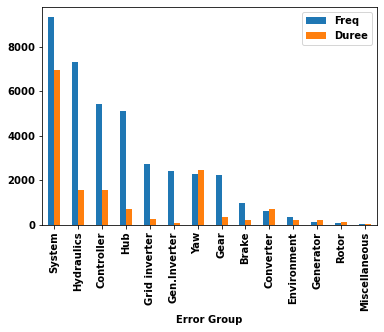

In [47]:
(cumul_alarms_result_sum.groupby('Error Group')
                        .agg(Freq=('Alarmcode', 'count'),
                             Duree=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                        .sort_values('Freq', ascending=False)
                        .reset_index()
                  ).plot(kind='bar', x='Error Group')

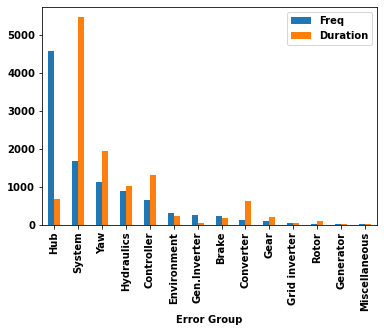

In [46]:
(cumul_parent_result_sum.groupby('Error Group')
                        .agg(Freq=('Alarmcode', 'count'),
                             Duration=('RealPeriod',
                                 lambda x: x.sum().total_seconds()/3600))
                        .sort_values('Freq', ascending=False)
                        .reset_index()
                  ).plot(kind='bar', x='Error Group')

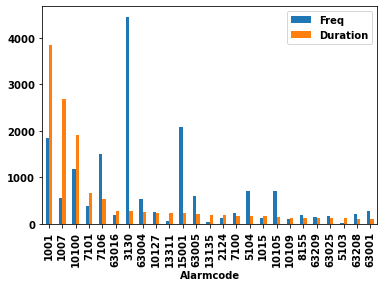

In [45]:
(cumul_alarms_result_sum.groupby('Alarmcode')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duration=('RealPeriod',
                                 lambda x: x.sum().total_seconds()/3600))
                  .sort_values('Duration', ascending=False)
                  .head(25)
                  .reset_index()
                  ).plot(kind='bar', x='Alarmcode')

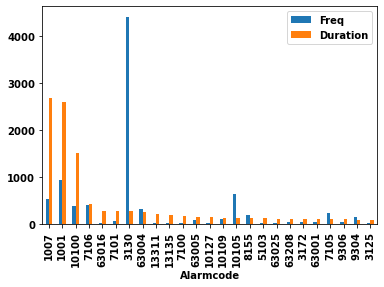

In [44]:
(cumul_parent_result_sum.groupby('Alarmcode')
                        .agg(Freq=('Alarmcode', 'count'),
                             Duration=('RealPeriod',
                                 lambda x: x.sum().total_seconds()/3600))
                        .sort_values('Duration', ascending=False)
                        .head(25)
                        .reset_index()
                  ).plot(kind='bar', x='Alarmcode')

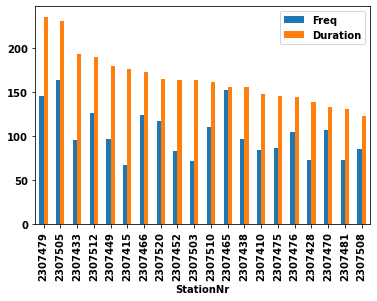

In [42]:
(cumul_parent_result_sum.groupby('StationNr')
                        .agg(Freq=('Alarmcode', 'count'),
                             Duration=('RealPeriod',
                                 lambda x: x.sum().total_seconds()/3600))
                        .sort_values('Duration', ascending=False)
                        .head(20)
                        .reset_index()
                  ).plot(kind='bar', x='StationNr')

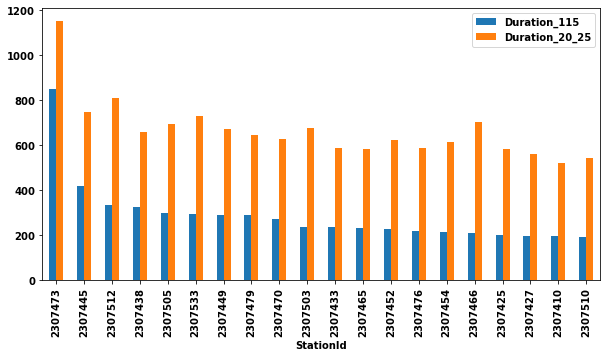

In [92]:
(cumul_results.groupby('StationId')
              .agg(Duration_115=('Duration 115(s)',
                                 lambda x: x.sum()/3600),
                   Duration_20_25=('Duration 20-25(s)',
                                 lambda x: x.sum()/3600))
              .sort_values('Duration_115', ascending=False)
              .head(20)
              .reset_index()
).plot(kind='bar', x='StationId', figsize=(10,5))

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

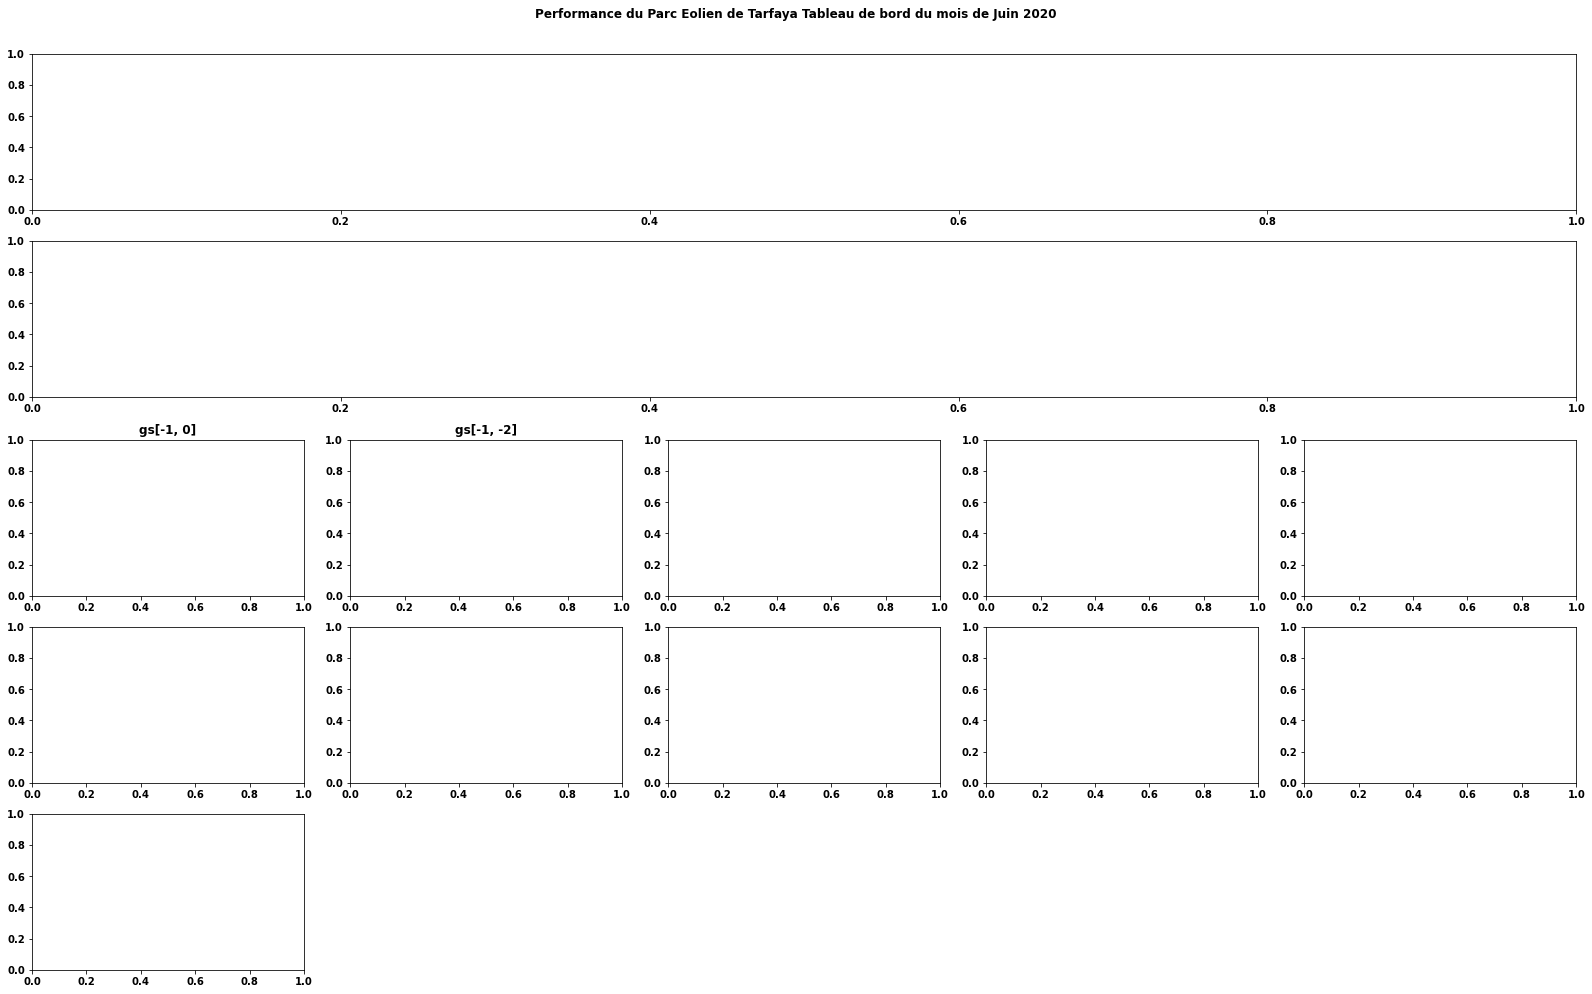

In [84]:
fig3 = plt.figure(constrained_layout=True)

gs = fig3.add_gridspec(6, 5)

# f3_ax1 = fig3.add_subplot(gs[0, :])
# f3_ax1.set_title('gs[0, :]')

f3_ax2 = fig3.add_subplot(gs[1-1, :])


f3_ax3 = fig3.add_subplot(gs[2-1, :])


f3_ax4 = fig3.add_subplot(gs[3-1, 0])
f3_ax4.set_title('gs[-1, 0]')

f3_ax5 = fig3.add_subplot(gs[3-1, 1])
f3_ax5.set_title('gs[-1, -2]')

f3_ax6 = fig3.add_subplot(gs[3-1, 2])

f3_ax7 = fig3.add_subplot(gs[3-1, 3])

f3_ax8 = fig3.add_subplot(gs[3-1, 4])

f3_ax9 = fig3.add_subplot(gs[4-1, 0])

f3_ax10 = fig3.add_subplot(gs[4-1, 1])

f3_ax11 = fig3.add_subplot(gs[4-1, 2])

f3_ax12 = fig3.add_subplot(gs[4-1, 3])

f3_ax13 = fig3.add_subplot(gs[4-1, 4])

f3_ax14 = fig3.add_subplot(gs[5-1, 0])

fig3.suptitle('Performance du Parc Eolien de Tarfaya Tableau de bord du mois de Juin 2020')


fig3.set_size_inches(22, 16)

In [85]:
5

(4,)